In [1]:
import numpy as np
import pandas as pd
import os

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib

import scipy.stats

import sys

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/mpra/utils") 

from misc import pearson_r, get_best_models, highlight_ns 

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'DNABERT':"#D55E00",'DNABERT-3UTR':"#ffac6a", 
                'DNABERT-2':"#3F3B6C",'DNABERT2-3UTR':"#adaad0",
                '13-mer':"#CC79A7",
                'PhyloP-241way':"#ffd373",
                'PhyloP-100way':"#e69f00",
                'StateSpace':"#0072B2", 'StateSpace-SA':"#59c3ff", 
                'NTv2-250M':"#009E73", 'NTv2-250M-3UTR':"#00dea2",
                'k-mer': 'k',
                'BC3MS(emb)':"#0072B2",
                'Saluki human':'#EC1649',
                'BC3MS':'#ECDE49',
                }

models = {'DNABERT': 'dnabert', 
          'DNABERT-3UTR': 'dnabert-3utr', 
          'DNABERT-2': 'dnabert2', 
          'DNABERT2-3UTR': 'dnabert2-3utr',
          'NTv2-250M': 'ntrans-v2-250m',
          'NTv2-250M-3UTR': 'ntrans-v2-250m-3utr',
          'StateSpace': 'stspace', 
          'StateSpace-SA': 'stspace-spaw',
          'k-mer': '3K'
         }

In [2]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/half_life/agarwal_2022/'

In [3]:
def compute_score_folds(x):
    df = len(x)-1 #number of folds minus 1
    ci_95 = scipy.stats.t.interval(0.95, df, loc=np.mean(x), scale=np.std(x))
    pearson_r = np.mean(x)
    ci_95 = np.diff(ci_95)[0]/2
    return (pearson_r, ci_95)

In [4]:
utr3_res = []

for regressor in ('Ridge','SVR'):
        
    for model, model_path in models.items():
        res_file = data_dir + f'predictions/{regressor}/{model_path}.tsv'
        df = pd.read_csv(res_file,sep='\t')
        scores = pearson_r(df.y_true,df.y_pred, compute_CI=True)
        utr3_res.append({'model':model,'score':scores,'regressor':regressor})

utr3_res = pd.DataFrame(utr3_res).pivot(index='model',columns='regressor').droplevel(0, axis=1)

In [5]:
best_models = utr3_res.apply(get_best_models)
        
utr3_res_ = utr3_res.map(lambda x: f'{x[0]:.2f}±{x[1]:.2f}' if isinstance(x,tuple) else 'none')

utr3_res_.loc[models.keys(),['Ridge','SVR']].style.apply(lambda x: highlight_ns(x, best_models))

regressor,Ridge,SVR
model,,
DNABERT,0.20±0.02,0.22±0.02
DNABERT-3UTR,0.27±0.02,0.27±0.02
DNABERT-2,0.32±0.02,0.35±0.02
DNABERT2-3UTR,0.30±0.02,0.32±0.02
NTv2-250M,0.31±0.02,0.34±0.02
NTv2-250M-3UTR,0.34±0.02,0.38±0.02
StateSpace,0.36±0.02,0.40±0.01
StateSpace-SA,0.33±0.02,0.39±0.01
k-mer,0.19±0.02,0.34±0.02


In [7]:
fullseq_res = pd.read_csv(data_dir + 'source_data/saluki_paper/Fig5_S6/experimentResults.csv')[['Saluki human','BC3MS']]
##paper_results2 = pd.read_csv(data_dir + 'data/saluki_paper/Fig3_S4/experimentResults.csv')[['B3']]
fullseq_res = fullseq_res.apply(compute_score_folds)

BC3M_best_emb = pd.read_csv(data_dir + f'predictions/SVR/BC3MS_stspace.tsv',sep='\t')

fullseq_res['BC3MS(emb)'] = pearson_r(BC3M_best_emb.y_true, BC3M_best_emb.y_pred, compute_CI=True)

fullseq_res.apply(lambda x: f'{x[0]:.2f}±{x[1]:.2f}')

Saluki human    0.77±0.03
BC3MS           0.67±0.04
BC3MS(emb)      0.68±0.01
dtype: object

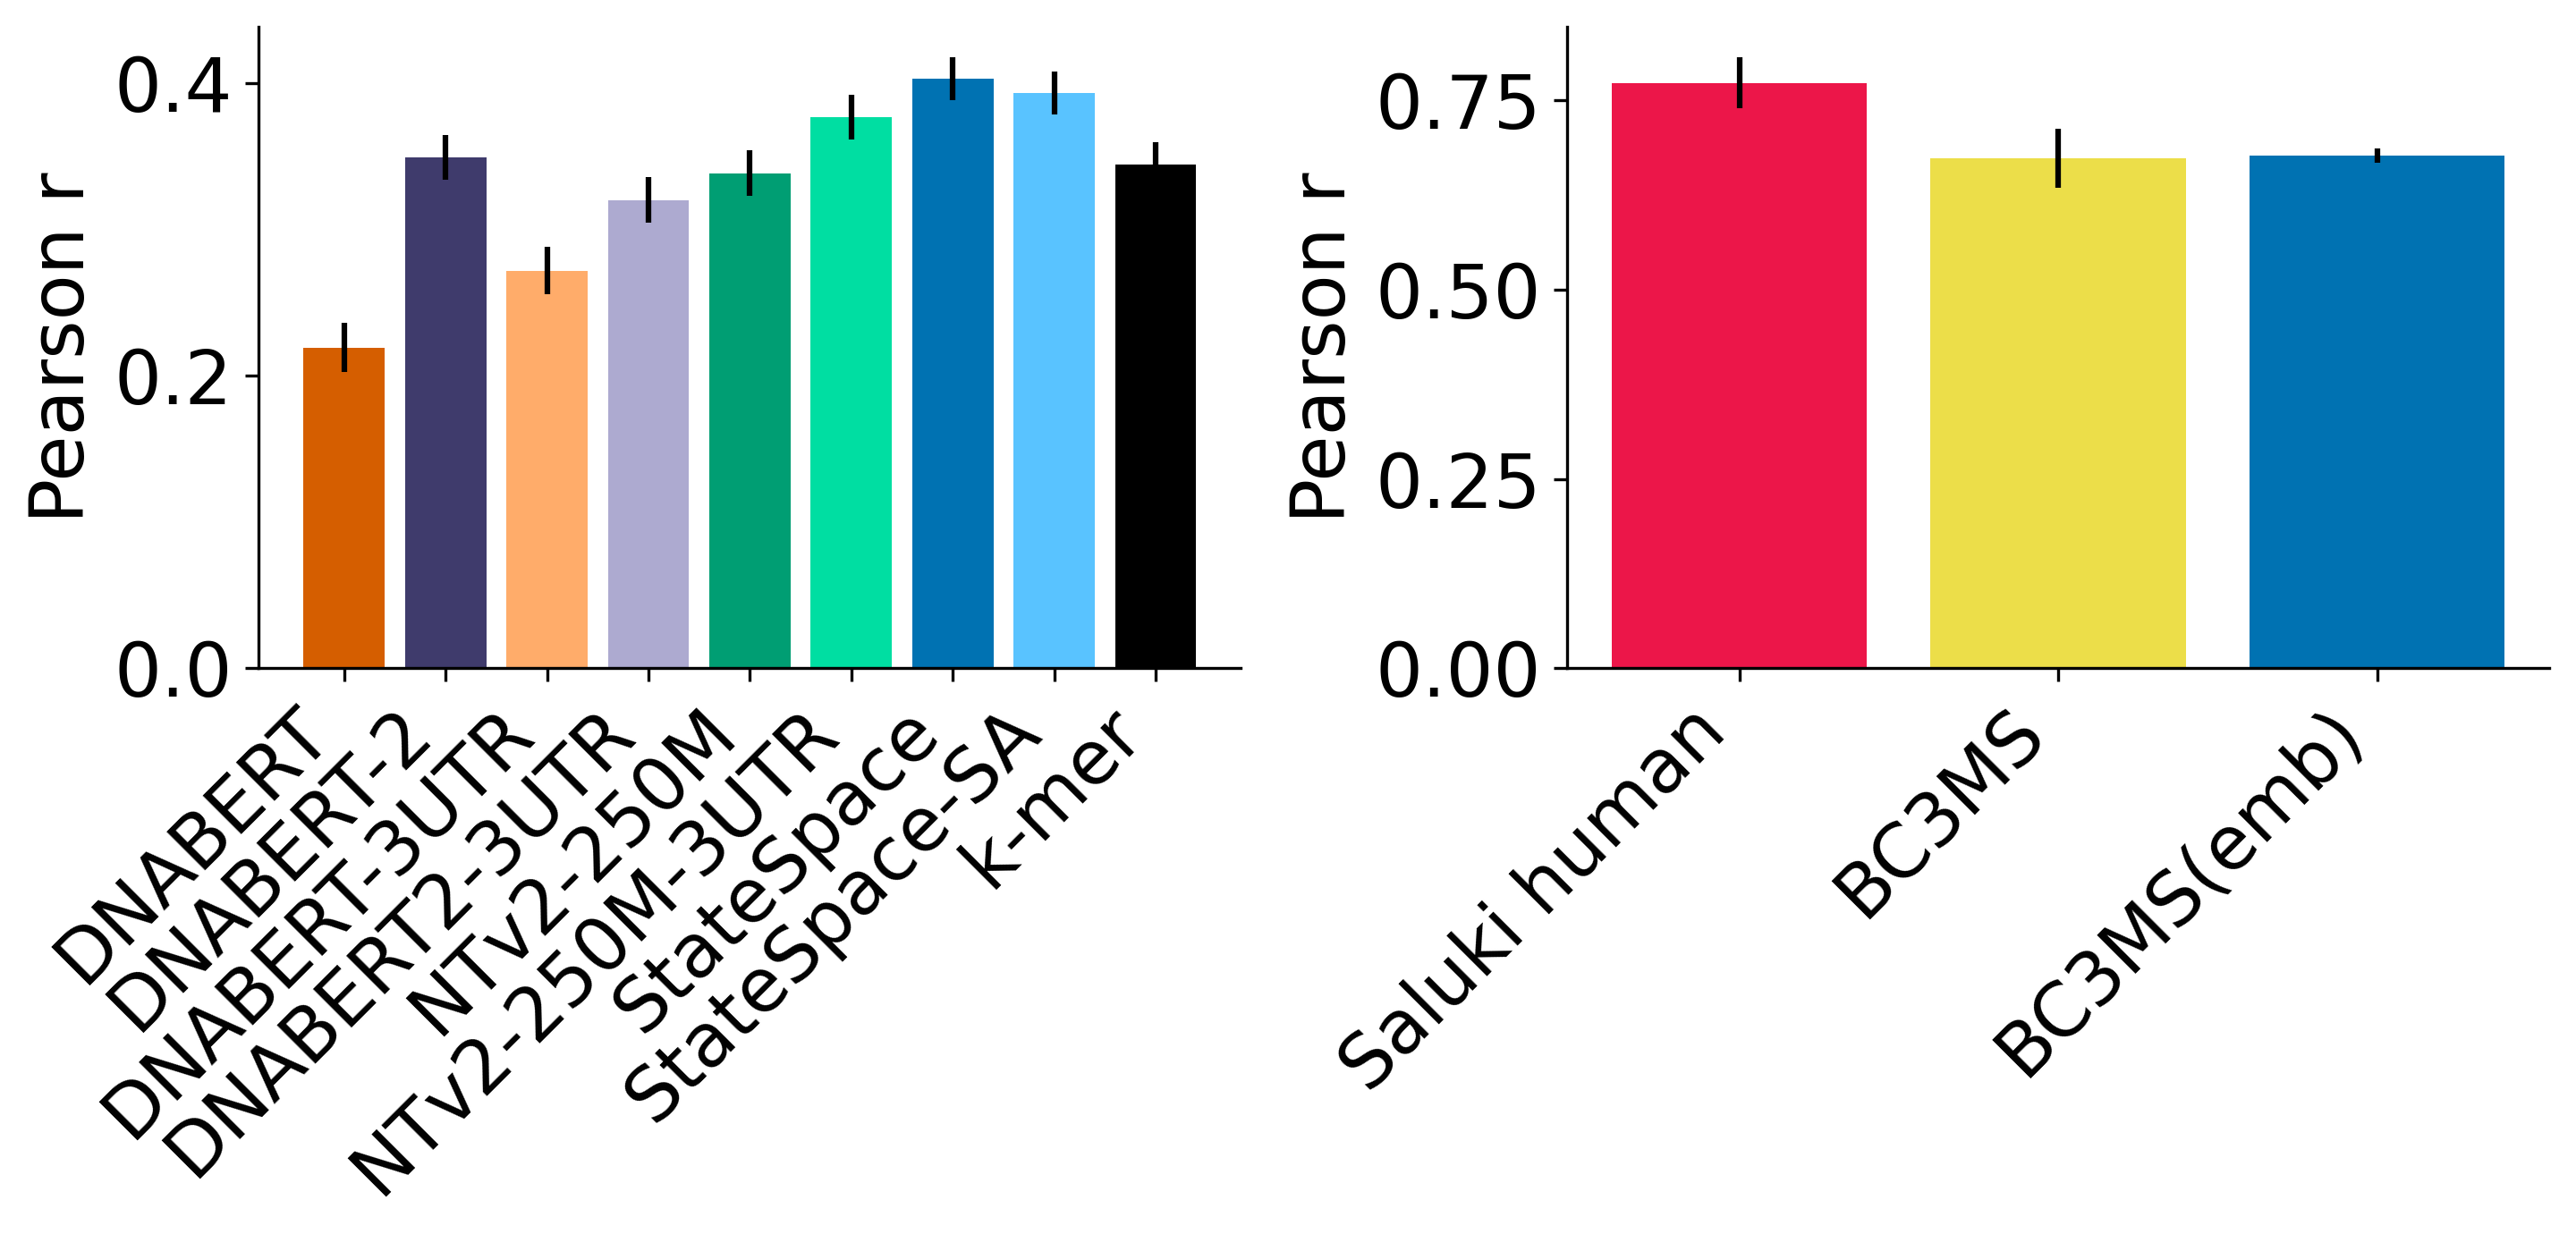

In [9]:
df = utr3_res.SVR

pearson_r, ci_95 = zip(*df.values.tolist())

fig, axes = plt.subplots(1,2,dpi=300, figsize=(10,5))

ax = axes[0]

ax.bar(df.index, pearson_r, yerr=ci_95, color=df.index.map(model_colors))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(),rotation=45, ha="right")
ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

df = fullseq_res.T
pearson_r, ci_95 = zip(*df.values.tolist())

ax = axes[1]

ax.bar(df.index, pearson_r, yerr=ci_95, color=df.index.map(model_colors))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(),rotation=45, ha="right")
ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()